<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-FFN-pytorch/ffn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Building Feed Forward Networks with `Pytorch`


## Init


In [1]:
import sys

sys.path.append("..")  # Add the parent directory to the path

from plot import plot_decision_regions

In [2]:
"""
cd .\02-FFN-pytorch-workflow\
jupyter nbconvert --to markdown ffn.ipynb --output README.md
"""
import torch
import torch.nn.functional as Fn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import optim

## The formal definition of an artificial neuron


More formally, we can put the idea behind artificial neurons into the context of a binary classification
task with two classes: 0 and 1. We can then define a decision function, $\sigma$, that takes a linear
combination of certain input values, $x$, and a corresponding weight vector, $w$, where $z$ is the so-called
net input $z = w_1x_1 + w_2x_2 + \ldots + w_mx_m$:

$$
w= \begin{bmatrix}
    w_1 \\
    \vdots \\
    w_m
\end{bmatrix},
x= \begin{bmatrix}
    x_1 \\
    \vdots \\
    x_m
\end{bmatrix}
$$

Now, if the net input of a particular example, $x^{(i)}$, is greater than a defined threshold, $\eta$, we predict class 1, and class 0 otherwise. In the perceptron algorithm, the decision function, $\sigma(\cdot)$, is a variant of a unit step function:

$$
\sigma(z) =
\begin{cases}
    1 & \text{if } z > \eta \\
    0 & \text{otherwise}
\end{cases}
$$

To simplify the code implementation later, we can modify this setup via a couple of steps. First, we move the threshold, $\eta$, to the left side of the equation:

$$
z \geq \eta \\
z - \eta \geq 0
$$

Second, we define a so-called bias unit as $b = -\eta$ and make it part of the net input:

$$
z = w_1x_1 + \ldots + w_mx_m + b = \mathbf{w}^T\mathbf{x} + b
$$

<p align="center">
<img src="img/02_02_unit_function.png" alt="02_02_unit_function.png" width="600px"/>
</p>


## The perceptron learning rule


The whole idea behind the MCP neuron and **Rosenblatt’s thresholded perceptron model** is to use a reductionist approach to mimic how a single neuron in the brain works: _it either fires or it doesn’t_. Thus,
Rosenblatt’s classic perceptron rule is fairly simple, and the perceptron algorithm can be summarized
by the following steps:

1. Initialize the weights and bias unit to `0` or small random numbers
2. For each training example, $x^{(i)}$:
   1. Compute the output value, $y^{(i)}$
   2. Update the weights and bias unit

Here, the output value is the class label predicted by the **unit step function** that we defined earlier, and the simultaneous update of the bias unit and each weight, $w_j$, in the weight vector, $w$, can be more
formally written as:

$$
w_j \leftarrow w_j + \Delta w_j \quad \text{and} \quad b \leftarrow b + \Delta b
$$

The update values (“deltas”) are computed as follows:

$$
\Delta w_j = \eta \cdot (y^{(i)} - \hat{y}^{(i)}) \cdot x_j^{(i)}
$$

$$
\Delta b = \eta \cdot (y^{(i)} - \hat{y}^{(i)})
$$

Each weight, $w_j$, corresponds to a feature, $x_j$, in the dataset, which is involved in determining the update value, $\Delta w_{ij}$, defined above. Furthermore, $\eta$ is the learning rate (typically a constant between 0.0 and 1.0), $y^{(i)}$ is the true class label of the $i$th training example, and $y^{(i)}$ is the predicted class label. It is important to note that the bias unit and all weights in the weight vector are being updated simultaneously, which means that we don’t recompute the predicted label, $y^{(i)}$, before the bias unit and all of the weights are updated via the respective update values, $\Delta w_{ij}$ and $\Delta b$.

In the two scenarios where the perceptron predicts the class label correctly, the bias unit and weights remain unchanged, since the update values are 0:

- $y^{(i)} = 0$, $y^{(i)} = 0$, $\Delta w_{ij} = \eta(0 - 0)x_j = 0$, $\Delta b = \eta(0 - 0) = 0$
- $y^{(i)} = 1$, $y^{(i)} = 1$, $\Delta w_{ij} = \eta(1 - 1)x_j = 0$, $\Delta b = \eta(1 - 1) = 0$

However, in the case of a wrong prediction, the weights are being pushed toward the direction of the positive or negative target class:

- $y^{(i)} = 1$, $y^{(i)} = 0$, $\Delta w_{ij} = \eta(1 - 0)x_j = \eta x_j$, $\Delta b = \eta(1 - 0) = \eta$
- $y^{(i)} = 0$, $y^{(i)} = 1$, $\Delta w_{ij} = \eta(0 - 1)x_j= -\eta x_j$, $\Delta b = -\eta(0 - 1) = -\eta$


It is important to note that the convergence of the perceptron is only guaranteed if the two classes
are linearly separable, which means that the two classes cannot be perfectly separated by a linear
decision boundary.

<p align="center">
<img src="img/llll.png" alt="ShapeCalculation.png" width="800px">
</p>

If classes can't be separated linearly, a perceptron can iterate through the training data for a set number of passes (`epochs`) or until a defined threshold of misclassifications is reached. This prevents the perceptron from endlessly updating weights. `Adaline`, a later algorithm, uses a different approach to produce linear decision boundaries and converges even when classes aren't perfectly separable.


## Implementing a perceptron learning algorithm in Python


### Generate Dataset


(1000, 2) (1000,)


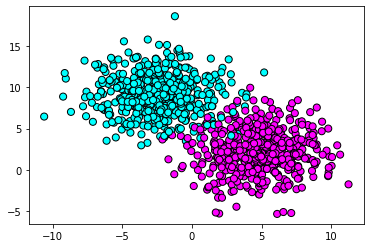

In [3]:
NUM_FEATURES = 2
NUM_CLASSES = 2
RANDOM_SEED = 42
X, y = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=RANDOM_SEED,
    cluster_std=2.5,
)
print(X.shape, y.shape)

# # Convert to tensors
# data = torch.from_numpy(data).type(torch.float)
# labels = torch.from_numpy(labels).type(torch.LongTensor)
# mymap = matplotlib.colors.LinearSegmentedColormap.from_list("",['red','yellow','green','blue'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.cool, edgecolors="k", s=50)

### Model


In [4]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    learning_rate : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """

    def __init__(self, learning_rate=0.01, n_iter=50, random_state=1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # self.w_ = np.zeros(X.shape[1])
        self.b_ = np.float_(0.0)

        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # Δ𝑤 = 𝜂(𝑦(𝑖) − output(𝑖)) 𝑥(𝑖)1
                update = self.learning_rate * (target - self.predict(xi))
                del_w = update * xi
                del_b = update
                self.w_ += del_w
                self.b_ += del_b
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

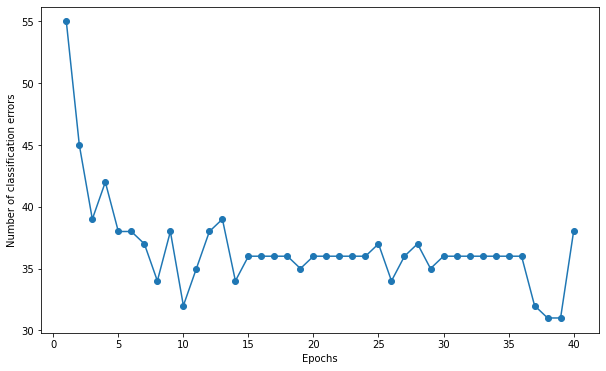

In [5]:
ppn = Perceptron(n_iter=40, learning_rate=10)

ppn.fit(X, y)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of classification errors")
# plt.savefig('images/02_07.png', dpi=300)
plt.show()

As we can see in Figure above, our perceptron converged after certain epoch and should now be able
to classify the training examples perfectly.


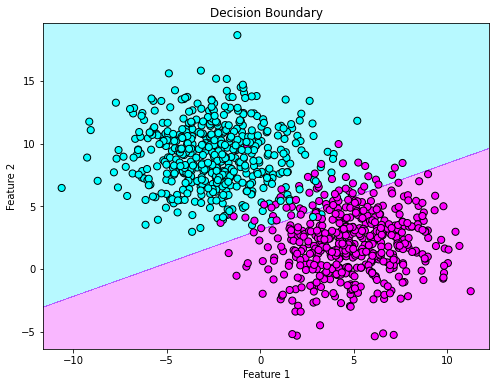

In [6]:
plot_decision_regions(X, y, classifier=ppn)

Notice that the initial weight vector contains small random numbers drawn from a normal distribution
with a standard deviation of `0.01` via `rgen.normal`.

Technically, we could initialize the weights to `zero` . However, if we did that, then the learning rate would have no effect on the decision boundary. If all the weights are initialized to `zero`, t**he learning rate parameter, affects only the scale of the weight vector, not the direction**.


In [8]:
def update_weights(
    w,
    input_vector,
    lr=0.1,
):
    dw_ = lr * input_vector
    return w + dw_


def calculate_angle(w, input_vector):
    dot_product = np.dot(w, input_vector)
    norm_w = np.linalg.norm(w)
    norm_input = np.linalg.norm(input_vector)
    """
    np.arccos is the trigonometric inverse cosine, and np.linalg.norm is a function that computes
    the length of a vector.
    """
    return np.degrees(np.arccos(dot_product / (norm_w * norm_input)))


w_zero = np.array([0, 0, 0])
w_norm = np.array([-0.00165135, -0.01933613, 0.00012572])
input_vector = np.array([1, 2, 3])

print(calculate_angle(update_weights(w_zero, input_vector, lr=0.1), input_vector))
print(calculate_angle(update_weights(w_zero, input_vector, lr=0.01), input_vector))
print(calculate_angle(update_weights(w_norm, input_vector, lr=0.1), input_vector))
print(calculate_angle(update_weights(w_norm, input_vector, lr=0.01), input_vector))

0.0
0.0
2.552882324525421
31.218586527045833


We can see that the angle between `input_vector` and `w_updated` is exactly zero.


## Adaptive linear neurons and the convergence of learning


The **Adaline** algorithm is particularly interesting because it illustrates the key concepts of defining and
minimizing **continuous loss functions**.

The key difference between the Adaline rule (also known as the Widrow-Hoff rule) and Rosenblatt’s
perceptron is that the **weights are updated based on a linear activation function rather than a unit step
function like in the perceptron**. In Adaline, the **linear activation function, $\sigma(z)$,** is simply the identity function of the net input, so that $\sigma(z) = z$. _While the linear activation function is used for learning the weights, we still use a threshold function to make the final prediction._


### Minimizing loss functions with gradient descent


#### Introduction to gradient


In calculus, the **gradient** represents the **rate of change or the slope of a function at a particular point in a multi-dimensional space**. It's a **vector that points in the direction of the steepest ascent(`moving up`) of a function at a given point**.

The gradient of a function $f$ in multi-dimensional space is denoted by $\nabla f$ and represented as:

$$
\nabla f = \frac{\partial f}{\partial x_1} \mathbf{i} + \frac{\partial f}{\partial x_2} \mathbf{j} + \ldots + \frac{\partial f}{\partial x_n} \mathbf{k}
$$

This equation showcases how the gradient is composed of partial derivatives with respect to each variable $ x_1, x_2, \ldots, x_n $ multiplied by their respective unit vectors $ \mathbf{i}, \mathbf{j}, \mathbf{k} $ in three dimensions. Vector Notation:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$$

Lets, consider a function $f(x) = x^2$ and its gradient $\nabla f(x) = 2x$, for better understanding


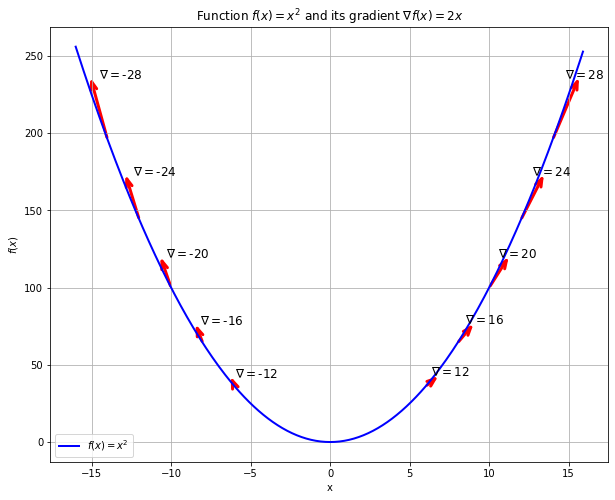

In [8]:
from helper import *

plot_gradient_one_var()

As illustrated in the figure, geometrically, **the direction of the gradient indicates the direction in which the function increases most rapidly, while the magnitude of the gradient represents the steepness of the slope.**

For the provided function $f(x) = x^2$, when $x = -6$, the corresponding $f(x)$ value is $36$, and the gradient $\nabla f(x)$ is $-12$. Moving $-12$ units in the $x$ direction (or, $x = x + \nabla f(x) = -18$),meaning in the direction of the gradient, will result in the greatest increase in the function value ($f(-18) = 324$).

Importantly, the magnitude of change varies with the magnitude of $x$, showcasing how the gradient captures both direction and steepness in relation to the function's input.


#### Full batch gradient descent


In the case of **Adaline**, we can define the loss function, $L$, to learn the model parameters as the **mean squared error (MSE)** between the calculated outcome and the true class label:

$$
L(\mathbf{w},b) = \frac{1}{2n} \sum_{i=1}^{n} \left(y^{(i)} - \sigma(\mathbf{w}^\top \mathbf{x}^{(i)}+\mathbf{b}^{(i)})\right)^2, or
$$

$$
L(\mathbf{w},b) = \frac{1}{2n} \sum_{i=1}^{n} \left(y^{(i)} - \sigma({z}^{(i)})\right)^2
$$

The term $1/2$ is just added for our convenience and will make it easier to derive the gradient of the loss function with respect to the weight parameters. The main advantage of this continuous linear activation function, in contrast to the unit step function, is that the loss function becomes differentiable. Another nice property of this loss function is that it is convex; thus, we can use a very simple yet powerful optimization algorithm called **gradient descent** to find the weights that minimize our loss function.

**In contrast to the prior scenario where moving in the direction of the gradient ($x = x + \nabla f(x)$) maximized the function, minimizing the loss involves moving in the opposite direction of the gradient ($x = x - \nabla f(x)$ or, equivalently, $w = w - \nabla L(w)$). This adjustment, dictated by the learning rate and the gradient's steepness ($w = w - \eta\nabla L(w)$, $b = b - \eta\nabla L(b)$), steers the parameter updates toward minimizing the loss function.**


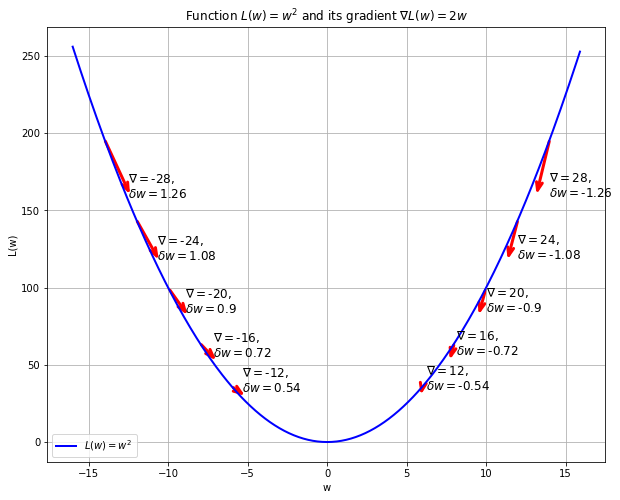

In [4]:
plot_gradient_descent_one_var()

<p align="center">
<img src="img/gd.jpg" alt="gd.jpg" width="500px"/>
</p>

In terms of gradient descent for the above given function $L(w) = w^2$, at $w = -6$, the corresponding loss $L(w)$ is $36$, and the gradient $\nabla L(w)$ is $-12$. To minimize the loss $L(w)$, we move opposite to the gradient, that is, updating $w$ as $w = w + (- \eta \cdot \text{grad})$ or $w = -6 +(- 0.1 \cdot (-12)) = -6 + 1.2 = -4.8$. This new value of $w$ results in a reduced loss, $L(w) = (-4.8)^2 = 23$, which is lower than the previous loss of $36$.

Therefore, the changes in parameters, $\Delta w$ and $\Delta b$, aiming to minimize the loss function $L(w)$, are defined as the negative gradient multiplied by the learning rate, $\eta$:

$$
\Delta w = -\eta \cdot \nabla L(w)
$$

$$
\Delta b = -\eta \cdot \nabla L(b)
$$

Here, $\nabla L(w)$ represents the gradient of the loss function $L$ with respect to the weight $w$, and $\nabla L(b)$ denotes the gradient of $L$ with respect to the bias $b$. These updates, scaled by the learning rate $\eta$, guide the parameter adjustments during the training process using gradient descent.

To compute the gradient of the loss function, we need to compute the partial derivative of the loss
function with respect to each weight, $w_j$:

$$
\frac{\partial L}{\partial w_j} = -\frac{2}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)}))x_j^{(i)}
$$

Similarly, we compute the partial derivative of the loss with respect to the bias as:

$$
\frac{\partial L}{\partial b} = -\frac{2}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)}))
$$

So we can write the weight update as:

$
\Delta w_j = -\eta \frac{\partial L}{\partial w_j}
$
and
$
\Delta b = -\eta \frac{\partial L}{\partial b}
$

Simultaneous Update (Adaline Learning Rule):

$$
\begin{align*}
w_j &\leftarrow w_j + \Delta w_j \\
b &\leftarrow b + \Delta b
\end{align*}
$$

Furthermore, the weight update is calculated based on all examples in the training dataset (instead of updating the parameters incrementally after each training example), which is why this approach is also referred to as **batch gradient descent** or **full batch gradient descent**.


In [7]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    learning_rate : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """

    def __init__(self, learning_rate=0.01, n_iter=50, random_state=1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples
        is the number of examples and
        n_features is the number of features.
        y : array-like, shape = [n_examples]
        Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.0)
        self.losses_ = []
        # implement full batch gradient descent
        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            # ∇L(w) = -(2/n)Σ(yi-σ(zi))xi
            grad_wrt_w = -2 * np.dot(X.T, errors) / X.shape[0]
            # Δw=−η⋅∇L(w)
            dw = -self.learning_rate * grad_wrt_w
            # w = w + Δw
            self.w_ += dw
            # ∇L(b) = -(2/n)Σ(yi-σ(zi))
            grad_wrt_b = -2 * np.sum(errors) / X.shape[0]
            # Δb=−η⋅∇L(b)
            db = -self.learning_rate * grad_wrt_b
            # b = b + Δb
            self.b_ += db
            # in short:
            # self.w_ += self.learning_rate * 2.0 * X.T.dot(errors) / X.shape[0]
            # self.b_ += self.learning_rate * 2.0 * errors.mean()
            loss = np.mean(errors**2)
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    # for classifying
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Instead of updating the weights after evaluating each individual training example, as in the perceptron,
we calculate the gradient based on the whole training dataset.

**Please note that the activation method has no effect on the code since it is simply an identity function**.Here, we added the activation function (computed via the activation method) to illustrate the general concept with regard to how information flows through a single-layer NN: features from the input data, net input, activation, and output.


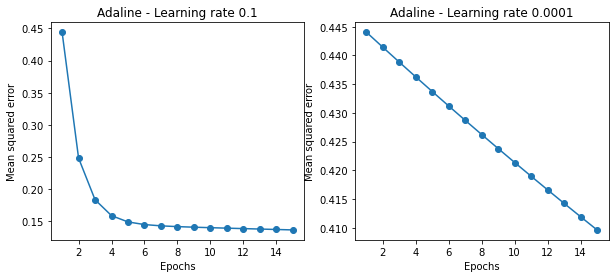

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=15, learning_rate=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Mean squared error")
ax[0].set_title("Adaline - Learning rate 0.1")

ada2 = AdalineGD(n_iter=15, learning_rate=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker="o")


ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean squared error")
ax[1].set_title("Adaline - Learning rate 0.0001")
plt.show()

we can see that the loss decreases on the right plot, but the chosen learning rate, `𝜂=0001` , is so small that the algorithm would require a very large number of epochs to converge to the global loss minimum


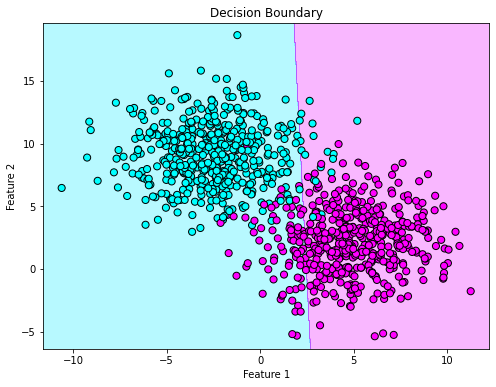

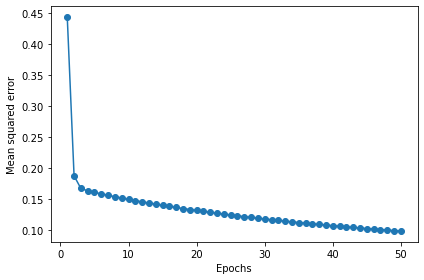

In [37]:
ada_gd = AdalineGD(n_iter=50, learning_rate=0.019)
ada_gd.fit(X, y)
plot_decision_regions(X=X, y=y, classifier=ada_gd)
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.tight_layout()
plt.show()

#### Mini batch gradient descent


Large-scale machine learning and stochastic gradient descent


In the previous section, we learned how to minimize a loss function by taking a step in the opposite
direction of the loss gradient that is calculated from the whole training dataset; this is why this approach
is sometimes also referred to as full batch gradient descent. Now imagine that we have a very large
dataset with millions of data points, which is not uncommon in many machine learning applications.
Running full batch gradient descent can be computationally quite costly in such scenarios, since we
need to reevaluate the whole training dataset each time we take one step toward the global minimum.


A popular alternative to the **batch gradient descent** algorithm is **stochastic gradient descent (SGD)**,
which is sometimes also called iterative or online gradient descent. Instead of updating the weights
based on the **sum of the accumulated errors over all training examples**, $x^{(i)}$:

$$
\Delta w_j = \frac{2\eta}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)})) \cdot x^{(i)}_j
$$

**we update the parameters incrementally for `each` training example**, for instance:

$$
\Delta w_j = \eta \cdot (y^{(i)} - \sigma(z^{(i)})) \cdot x^{(i)}_j
$$

$$
\Delta b = \eta \cdot (y^{(i)} - \sigma(z^{(i)}))
$$

Although `SGD` can be considered as an _approximation of gradient descent, it typically reaches convergence much faster because of the more frequent weight updates._ Since each gradient is calculated
based on a single training example, the error surface is noisier than in gradient descent, which can
also have the advantage that SGD can escape shallow local minima more readily if we are working
with nonlinear loss functions.

_To obtain satisfying results via SGD, it is important to present training data in a random order; also, we want to shuffle the training dataset for every epoch to prevent cycles._

Another advantage of SGD is that we can use it for online learning. In online learning, our model is
trained on the fly as new training data arrives. This

**Mini-batch gradient descent** is a compromise between **full batch gradient descent and stochastic gradient descent (SGD)**. It involves applying full batch gradient descent to smaller subsets of the training data, such as 32 examples at a time. This approach accelerates convergence by enabling more frequent weight updates. Additionally, mini-batch learning allows for efficient vectorized operations, allowing us to replace the `for` loop over the training examples in SGD.


Code implementation:

Inside the `fit` method, we will now update the weights after each training example. Furthermore, we will implement an additional `partial_fit` method, which does not reinitialize the weights, for online learning. In order to check whether our algorithm converged after training, we will calculate the loss as the average loss of the training examples in each epoch. Furthermore, we will add an option to shuffle the training data before each epoch to avoid repetitive cycles when we are optimizing the loss function; via the random_state parameter, we allow the specification of a random seed for reproducibility:


In [56]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """

    def __init__(self, learning_rate=0.01, n_iter=10, shuffle=True, random_state=69):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.
        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without re-initializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.0)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = target - output
        grad_w = 2.0 * xi * (error)
        dw = self.learning_rate * grad_w
        self.w_ += dw
        grad_b = 2.0 * (error)
        db = self.learning_rate * grad_b
        self.b_ += db
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    # for classifying
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

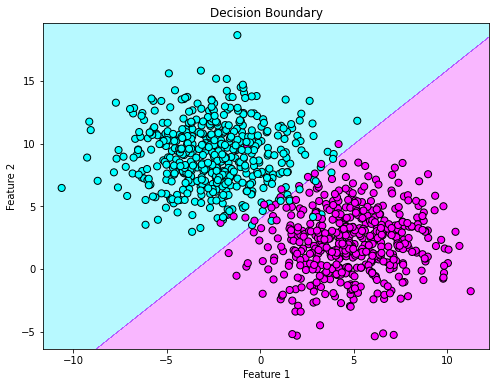

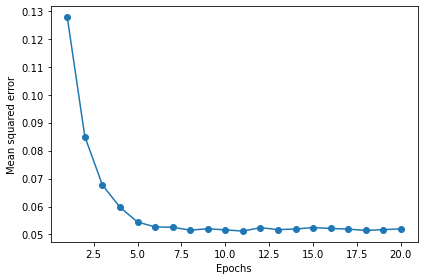

In [78]:
ada_gd = AdalineGD(n_iter=20, learning_rate=0.001)
ada_gd.fit(X, y)
plot_decision_regions(X=X, y=y, classifier=ada_gd)
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.tight_layout()
plt.show()

If we want to update our model, for example, in an online learning scenario with streaming data, we could simply call the partial_fit method on individual training examples—for instance, `ada_sgd.partial_fit(X_new(i), y(i)).`


In [79]:
online_data_X, online_data_y = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=RANDOM_SEED,
    cluster_std=2.5,
)
print(online_data_X.shape, online_data_y.shape)

(1000, 2) (1000,)


In [80]:
print(ada_gd.w_)

ada_gd.partial_fit(online_data_X[0, :], online_data_y[0])

print(ada_gd.w_)

[ 0.06636402 -0.05597241]
[ 0.06665753 -0.06029854]


## Using torch tensor and autograd


<p align="center">
<img src="img/ShapeCalculation.png" alt="ShapeCalculation.png" width="900px">
</p>


In [ ]:
torch.manual_seed(0)
W1 = torch.randn(10, 2) / math.sqrt(2)  # Shape-> (L_out,L_in)
W1.requires_grad_()
b1 = torch.zeros(10, requires_grad=True)

W2 = torch.randn(4, 10) / math.sqrt(2)  # Shape-> (L_out,L_in)
W2.requires_grad_()
b2 = torch.zeros(4, requires_grad=True)

print(W1.shape, W2.shape)

In [ ]:
def model(X):
    a1 = torch.matmul(X, W1.T) + b1  # (N,2) x (2,10)^T => (N,10)
    # print(a1.shape)
    h1 = a1.sigmoid()  # (N,10)
    # print(h1.shape)
    a2 = torch.matmul(h1, W2.T) + b2  # (N,10) x (10,4)^T => (N,4)
    # print(a2.shape)
    h2 = a2.softmax(dim=1)  # (N,4)
    # print(h2.shape)
    return h2

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

In [ ]:
learning_rate = 0.2
epochs = 2000

X_train = X_train.float()
Y_train = y_train.long()

loss_err = []
acc_err = []

for epoch in range(epochs):
    y_hat = model(X_train)
    loss = Fn.cross_entropy(y_hat, Y_train)
    loss_err.append(loss.item())
    acc_err.append(accuracy_fn(y_hat, y_train))
    loss.backward()

    with torch.no_grad():
        W1 -= W1.grad * learning_rate
        b1 -= b1.grad * learning_rate
        W2 -= W2.grad * learning_rate
        b2 -= b2.grad * learning_rate

        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

plt.plot(loss_err, "r-")
plt.plot(acc_err, "b-")

print(f"Loss before training : {loss_err[0]}")
print(f"Loss after training : {loss_err[-1]}")

## Using `NN.Parameter`


In [ ]:
# def model(X):
#     a1 = torch.matmul(X,W1.T) + b1 # (N,2) x (2,10)^T => (N,10)
#     # print(a1.shape)
#     h1 = a1.sigmoid() # (N,10)
#     # print(h1.shape)
#     a2 = torch.matmul(h1,W2.T) + b2 # (N,10) x (10,4)^T => (N,4)
#     # print(a2.shape)
#     h2 = a2.softmax(dim=1) # (N,4)
#     # print(h2.shape)
#     return h2
# torch.manual_seed(0)
# W1 = torch.randn(10,2) / math.sqrt(2) # Shape-> (L_out,L_in)
# W1.requires_grad_()
# b1 = torch.zeros(10,requires_grad=True)

# W2 = torch.randn(4,10) / math.sqrt(2) # Shape-> (L_out,L_in)
# W2.requires_grad_()
# b2 = torch.zeros(4,requires_grad=True)

# print(W1.shape,W2.shape)

In [ ]:
class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.W1 = nn.Parameter(torch.randn(10, 2, dtype=torch.float) / math.sqrt(2))
        self.b1 = nn.Parameter(torch.zeros(10))
        self.W2 = nn.Parameter(torch.randn(4, 10, dtype=torch.float) / math.sqrt(2))
        self.b2 = nn.Parameter(torch.zeros(4))

    def forward(self, X):
        a1 = torch.matmul(X, self.W1.T) + b1
        h1 = a1.sigmoid()

        a2 = torch.matmul(h1, self.W2.T) + b2
        h2 = a2.softmax(dim=1)

        return h2


model = FirstNetwork()

In [ ]:
def fit(epochs=2000, learning_rate=1):
    loss_err = []
    acc_err = []
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = Fn.cross_entropy(y_hat, y_train)
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat, y_train))

        loss.backward()

        # with torch.no_grad():
        #     W1 -= W1.grad * learning_rate
        #     b1 -= b1.grad * learning_rate
        #     W2 -= W2.grad * learning_rate
        #     b2 -= b2.grad * learning_rate

        #     W1.grad.zero_()
        #     b1.grad.zero_()
        #     W2.grad.zero_()
        #     b2.grad.zero_()

        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param -= learning_rate * param.grad
            model.zero_grad()

    plt.plot(loss_err, "r-")
    plt.plot(acc_err, "b-")
    print(f"Loss before training : {loss_err[0]}")
    print(f"Loss after training : {loss_err[-1]}")


fit()

## Using `NN.Linear` and `Optim`


In [ ]:
class NNLinearNetwork_v1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        # self.W1 = nn.Parameter(torch.randn(10,2, dtype=torch.float)/math.sqrt(2))
        # self.b1 = nn.Parameter(torch.zeros(10))
        # self.W2 = nn.Parameter(torch.randn(4,10, dtype=torch.float)/math.sqrt(2))
        # self.b2 = nn.Parameter(torch.zeros(4))

        self.l1 = nn.Linear(in_features=2, out_features=10)
        self.l2 = nn.Linear(10, 4)

    def forward(self, X):
        # a1= torch.matmul(X,self.W1.T)+b1
        a1 = self.l1(X)
        h1 = a1.sigmoid()

        # a2 = torch.matmul(h1,self.W2.T)+b2
        a2 = self.l2(h1)
        h2 = a2.softmax(dim=1)

        return h2


model = NNLinearNetwork_v1()

In [ ]:
def fit(epochs=2000, learning_rate=1):
    loss_err = []
    acc_err = []
    opt = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = Fn.cross_entropy(y_hat, y_train)
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat, y_train))

        loss.backward()
        opt.step()
        opt.zero_grad()

        # with torch.no_grad():
        #     for param in model.parameters():
        #         if param.grad is not None:
        #             param -= learning_rate * param.grad
        #     model.zero_grad()

    plt.plot(loss_err, "r-")
    plt.plot(acc_err, "b-")
    print(f"Loss before training : {loss_err[0]}")
    print(f"Loss after training : {loss_err[-1]}")


fit()

## Using `NN.Sequential`


In [ ]:
class NNLinearNetwork_v2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        # self.l1 = nn.Linear(in_features=2,out_features=10)
        # self.l2 = nn.Linear(10,4)
        self.net = nn.Sequential(
            nn.Linear(2, 10), nn.Sigmoid(), nn.Linear(10, 4), nn.Softmax(dim=1)
        )

    def forward(self, X):
        # a1 = self.l1(X)
        # h1 = a1.sigmoid()
        # a2 = self.l2(h1)
        # h2 = a2.softmax(dim=1)
        # return h2
        return self.net(X)

In [ ]:
def fit(x, y, model, opt, loss_fn, epochs=2000, log=False):
    loss_err = []
    acc_err = []
    for epoch in range(epochs):
        loss = loss_fn(model(x), y)
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat, y_train))

        loss.backward()
        opt.step()
        opt.zero_grad()

    if log:
        plt.plot(loss_err, "r-")
        plt.plot(acc_err, "b-")
        print(f"Loss before training : {loss_err[0]}")
        print(f"Loss after training : {loss_err[-1]}")


model = NNLinearNetwork_v2()
loss_fn = Fn.cross_entropy
opt = optim.SGD(model.parameters(), lr=1)

fit(x=X_train, y=y_train, model=model, opt=opt, loss_fn=loss_fn, log=True)

## Running in GPU


In [ ]:
class NNLinearNetwork_v3(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2, 1024 * 4),
            nn.Sigmoid(),
            nn.Linear(1024 * 4, 4),
            nn.Softmax(dim=1),
        )

    def forward(self, X):
        return self.net(X)

In [ ]:
def fit(x, y, model, opt, loss_fn, epochs=2000, log=False):
    loss_err = []
    acc_err = []
    for epoch in range(epochs):
        loss = loss_fn(model(x), y)
        loss_err.append(loss.item())

        loss.backward()
        opt.step()
        opt.zero_grad()

    if log:
        print(f"Loss before training : {loss_err[0]}")
        print(f"Loss after training : {loss_err[-1]}")

In [ ]:
device = torch.device("cpu")  # cuda #cpu
print(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
model = NNLinearNetwork_v3().to(device)
model.to(device)

In [ ]:
%%time
loss_fn = Fn.cross_entropy
opt = optim.SGD(model.parameters(),lr=1)
fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)


In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
model = NNLinearNetwork_v3().to(device)

fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)